In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return list(allsubs)

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p[0].shape)

(830, 34716)


In [69]:
import torch
import torch.nn as nn

import pickle

ntrain = 800
shuffle = torch.randperm(p[0].shape[0])
mseLoss = nn.MSELoss()

x = torch.cat([torch.from_numpy(p[2]), torch.ones(p[0].shape[0],1)], dim=1).float().cuda()
x = x[shuffle]
xtr = x[0:ntrain]
xt = x[ntrain:]

y = get_y(metadict, ['age'], subs)[0]
y = torch.from_numpy(y).float().cuda()
y = y[shuffle]
ytr = y[0:ntrain]
yt = y[ntrain:]

w, _, _, _ = torch.linalg.lstsq(xtr,ytr)
yhat = xt@w
rmse = mseLoss(yhat, yt)**0.5
print(rmse)

class Features:
    def __init__(self, w, b, subs, desc):
        self.w = self.to_numpy(w)
        self.b = self.to_numpy(b)
        self.subs = subs
        self.desc = desc
        
    def to_numpy(self, data):
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        elif isinstance(data, numpy.ndarray):
            return data
        else:
            raise TypeError(data)
            
    def save(self, fname):
        with open(fname, 'wb') as f:
            pickle.dump(self, f)
            
feat = Features(w[:34716], 
                w[34716:], 
                sorted([subs[i] for i in shuffle]), 
                f"Least squares age emoid rmse: {float(rmse)}")

tensor(24.4671, device='cuda:0')


In [70]:
fname = "/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/features/emoid3.pkl"
feat.save(fname)

print('Complete')

Complete


In [6]:
odir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/fc'

for i in range(len(subs)):
    fname = f'{odir}/{subs[i]}_task-emoid_fc'
    np.save(fname, p[2][i], allow_pickle=False)
    if i % 50 == 0:
        print(f'Done {i}')
    
print('Complete')

Done 0
Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Complete


34716


'iVBORw0KGgoAAAANSUhEUgAAAgAAAAGiCAYAAACRRH6CAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9aaxtaXrXCf7eaQ17POOdYs6InCfjgcTVSSFjV7mqADXqCXcjYYFAgsIfjEsMVnWDXeqGblFCBtnV/kBRFuqWGqguI3UnBZgEnNhKeU7bmWRGZmQMN+IO555xT2t8h/7wrL1vJpBtQ0RmOOzzSEcR59w9rOFd7zP9n/9fpZQS13Zt13Zt13Zt1/Y7yvTbfQDXdm3Xdm3Xdm3X9o236wDg2q7t2q7t2q7td6BdBwDXdm3Xdm3Xdm2/A+06ALi2a7u2a7u2a/sdaNcBwLVd27Vd27Vd2+9Auw4Aru3aru3aru3afgfadQBwbdd2bdd2bdf2O9CuA4Bru7Zru7Zru7bfgXYdAFzbtV3btV3btf0OtOsA4Nqu7dqu7dqu7XegXQcA13Zt13Zt13Ztb6F96lOf4g/9oT/EnTt3UErxD//hP/wN3/Mv/+W/5Ju/+ZvJ85wXXniBn/iJn/i6H+fbGgD82I/9GM8++yxFUfCxj32Mn//5n387D+faru3aru3aru1N22az4aMf/Sg/9mM/9pt6/SuvvMIf+AN/gO/4ju/gM5/5DN///d/Pn/yTf5J/8k/+ydf1ONXbJQb09/7e3+OP/bE/xo//+I/zsY99jB/5kR/hH/yDf8CLL77IjRs33o5DurZru7Zru7Zre0tNKcVP/uRP8of/8B/+mq/5i3/xL/KJT3yCz372s7u/fc/3fA9XV1f843/8j79ux2a/bp/8G9jf+Bt/gz/1p/4Uf/yP/3EAfvzHf5xPfOIT/J2/83f4S3/pL33Va9u2pW3b3e8xRi4uLjg8PEQp9Q097mu7tmu7tmt785Z

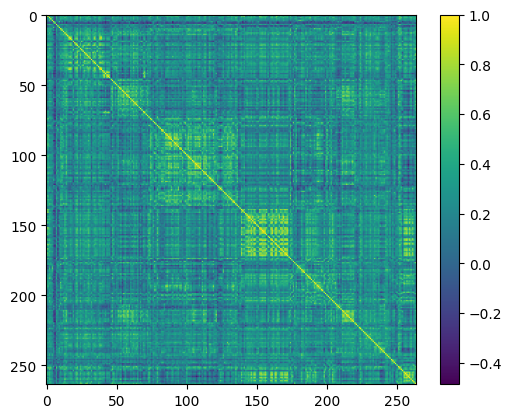

In [5]:
fc = np.load(fname+'.npy')

import io
import base64
import matplotlib.pyplot as plt

def fcvec2mat(fc):
    n = len(fc)
    d = int(round((1+(1+8*n)**0.5)/2))
    a,b = np.triu_indices(d,1)
    mat = np.zeros((d,d))
    mat[a,b] = fc
    mat += mat.T
    ones = np.arange(d)
    mat[ones,ones] = 1
    return mat

def imshow(fc, colorbar=True):
    fc = fcvec2mat(fc)
    fig, ax = plt.subplots()
    im = ax.imshow(fc)
    if colorbar:
        fig.colorbar(mappable=im, ax=ax)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    return base64.b64encode(buf.read()).decode()

fc = p[1][0]
print(len(fc))
imshow(fc)

In [3]:
type(list(metadict['age'].keys())[0])

int

In [9]:
fname = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/demographics.pkl'

tasks = ['age', 'sex', 'wrat']
demo = {task: {} for task in tasks}
subs_list = list(subs)

for i in range(len(subs)):
    for task in tasks:
        demo[task][f'{subs[i]}'] = metadict[task][subs_list[i]]

with open(fname, 'wb') as f:
    pickle.dump(demo, f)
    
print('Complete')

Complete
